![Lojistik Regresyon Tek Noronlu NN Görseli](breast_cancer_perceptron_manual_vs_sklearn/assets/gorseller_perceptron.jpg)
Taken from DATAI Team Deep Learning Udemy Course

#### Base Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow

#### Data Load

In [2]:
# Load data from the sklearn datasets
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

#### Null Value Control

In [4]:
# Check if there are any null values, because:
# Perceptron-like models are very sensitive to NULL/NaN/None values.
# These cause uncalculable weights or incorrect calculations.
# If any NULL/NaN/None exists among X1, X2, ..., Xn, this results in NULL/NaN/None values in the matrix calculations and may throw an error
# (for example: ValueError, FloatingPointError, etc.).
# As a result, NULL/NaN/None values block updating the perceptron's parameters.

df.isnull().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
dtype: int64

<Axes: xlabel='target', ylabel='count'>

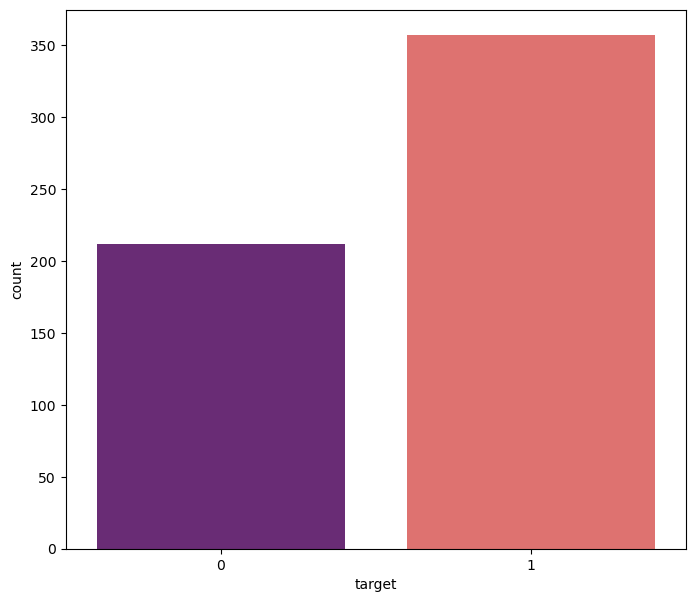

In [5]:
# Checking for imbalanced data:
# Most classic models, like perceptron and regression, are also sensitive to imbalanced datasets.
# That's why this problem should be addressed before starting modeling.
# Common methods include:
#   - Resampling: Using techniques like SMOTE to increase the minority class (oversampling), or reducing the majority class (undersampling).
#   - Weighted Loss Function: Applying higher penalties to misclassified minority class samples.
#   - Evaluating the model with metrics beyond accuracy, such as precision, recall, and F1-score.

plt.figure(figsize = (8,7))
sns.countplot(x="target", hue="target", data=df, palette="magma", legend=False)

In [6]:
# Identifing the datasets

df_ = df.iloc[:,:-1]
dfy = df.iloc[:, -1]

#### Splitting and Scaling Data

In [7]:
# Step 1 :
from sklearn.model_selection import train_test_split

x_train , x_test, y_train, y_test = train_test_split(df_, dfy, test_size = 0.2, random_state = 42)

In [8]:
# Step 2 :

# There is an important point to be careful about:
# The difference between fit_transform and transform:
# - fit_transform: Calculates the mean and standard deviation **from X_train** and transforms the training data.
# - transform: Applies the transformation to X_test using the mean and standard deviation learned **from X_train**.
# If you apply fit_transform directly on X_test, this causes "data leakage."


from sklearn.preprocessing import MinMaxScaler

scale = MinMaxScaler()
x_train_scaled = scale.fit_transform(x_train)
x_test_scaled = scale.transform(x_test)

#### Initializing the weights and bias

In [9]:
# Step 3 :
# Identify the number of features (dimension) to initialize the weight matrix w with the correct shape.
dimension = x_train_scaled.shape[1]
dimension

30

In [10]:
# Step 4 :
# Initialize the weight and bias values
def intialize_w_b(dimension):
    w = np.full((dimension,), 0.01)
    b = 0
    return w, b

In [11]:
# Step 5 :
# Applied the initialize function :
w , b = intialize_w_b(dimension)

In [12]:
# I cheked the shape of the data sets. That will be useful later calculations with matrixes.

print(f'x_train_scaled shape...: {x_train_scaled.shape}')
print(f'x_test_scaled shape...: {x_test_scaled.shape}')
print(f'y_train shape...: {y_train.shape}')
print(f'y_test shape...: {y_test.shape}')

x_train_scaled shape...: (455, 30)
x_test_scaled shape...: (114, 30)
y_train shape...: (455,)
y_test shape...: (114,)


In [13]:
# Step 6 :
# Identified the zed function for the forward propagation. It will be the part of the calculation.
def zed(w, x_train_scaled, b):
    z = x_train_scaled.dot(w) + b
    return z

In [14]:
z_tr = zed(w, x_train_scaled, b)
z_tr.shape

(455,)

In [15]:
# Step 7 :
# Identified the sigmoid function.

#           σ(x) = 1 / (1 + e^-z)  

# Output is always between 0 and 1 (0-1)
# Is is S curve graph
# 
def sigmoid(z):
    y_head = 1 / (1 + np.exp(-z))
    return y_head

In [16]:
# Step 8:
# Applied the sigmoid function to the z values.
# This transforms raw scores into probability values between 0 and 1.
y_head = sigmoid(z_tr)

# Reshaped y_head to a 1D vector for element-wise operations 
# and to match the shape of y_true during loss calculation.
y_head = y_head.reshape(-1)
y_head.shape

(455,)

In [17]:
# Step 9:
# Forward Propagation Step
# in order to calculate the weights and biases and cost value  :
def forward_propagation(w,b, x_train_scaled, y_head, y_train):
    loss = -y_train * np.log(y_head) - (1 - y_train) * np.log(1 - y_head)
    cost = np.sum(loss) / x_train_scaled.shape[0]
    return cost

In [18]:
# Step 10 :
# Calculation of  Cost value:
cost = forward_propagation(w,b, x_train_scaled, y_head, y_train)
print(f'Cost Value...: {cost}')

Cost Value...: 0.6949844001196673


In [19]:
# Step 11 :
# Backpropagation step:
# Computed the gradients of the loss function with respect to weights and bias.
def back_propagation(x_train_scaled, y_train):
    # These represent the partial derivatives dw = ∂L/∂w and db = ∂L/∂b, respectively.
    dw = (x_train_scaled.T).dot(((y_head-y_train)))/x_train_scaled.shape[0] 
    db = np.sum(y_head-y_train)/x_train_scaled.shape[0] 
    #gradients = {"derivative_weight": derivative_weight,"derivative_bias": derivative_bias}
    return dw, db

In [20]:
back_propagation(x_train_scaled, y_train)

(array([ 0.02605381, -0.00604854,  0.02742051,  0.02888889, -0.01977355,
         0.02044274,  0.0395879 ,  0.04573314, -0.01276596, -0.03049883,
         0.01558964, -0.02064539,  0.01446199,  0.01555066, -0.02264232,
        -0.00163174, -0.00037942, -0.00247258, -0.02559334, -0.00895618,
         0.03542324, -0.00288572,  0.03481295,  0.03193699, -0.01219212,
         0.02195093,  0.0291955 ,  0.04349479, -0.0023122 , -0.00358517]),
 -0.11060237343342817)

Epoch    0  Cost: 0.6950
Epoch  100  Cost: 0.2866
Epoch  200  Cost: 0.2208
Epoch  300  Cost: 0.1908
Epoch  400  Cost: 0.1724
Epoch  500  Cost: 0.1595
Epoch  600  Cost: 0.1498
Epoch  700  Cost: 0.1421
Epoch  800  Cost: 0.1358
Epoch  900  Cost: 0.1305


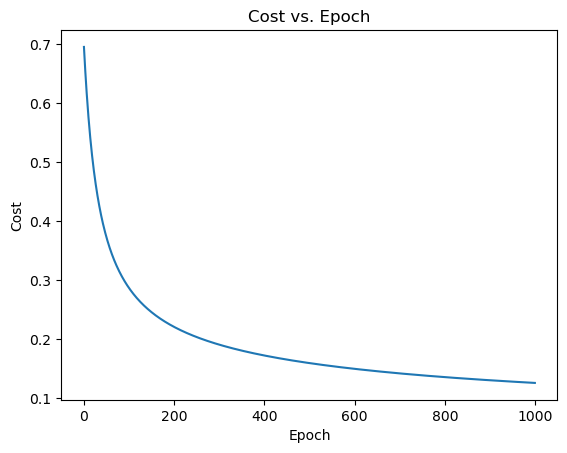

In [21]:
# Step 12 :
# Prdiction of the Model and Cost vs Epochs Plot

lr = 0.5 # Learning Rate 
epochs = 1000
costs = []
for epoch in range(epochs):
    
    z = np.dot(x_train_scaled, w) + b
    y_head = sigmoid(z)
    
    # forward propagation :
    cost = forward_propagation(w,b, x_train_scaled, y_head, y_train)

    #back propagation:
    dw, db = back_propagation(x_train_scaled, y_train)


    #updating w and b :
    w -= lr * dw
    b -= lr * db

    costs.append(cost)
    
    # epochs watch :
    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d}  Cost: {cost:.4f}")


import matplotlib.pyplot as plt
plt.plot(range(epochs), costs)
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('Cost vs. Epoch')
plt.show()

    

### 📉 Cost vs. Epoch

The graph above shows how the cost value decreases over the training epochs. As seen in the curve, the loss drops significantly in the early epochs, especially between 0 and 200. After around the **800th epoch**, the improvement becomes marginal and the curve starts to **plateau**, indicating that the model is no longer learning meaningful patterns from the data.

This is a good place to implement **early stopping**, a technique where training is halted once the cost no longer improves significantly. This helps save computation time and prevents overfitting by stopping the training before the model begins to memorize the data.


In [22]:
# Step 13 :
# Calculate model predictions on the test dataset to evaluate generalization performance:
z_test = x_test_scaled.dot(w) + b
y_head_test = sigmoid(z_test).reshape(-1)

#### **Manuel Model Results:**

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

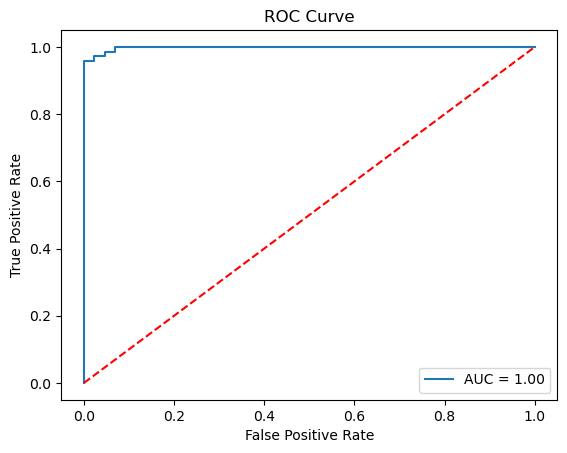

In [24]:
# Step 14 Evaluation of the Manuel Model :
# By default, the classification threshold is set to 0.5.
# Model predictions above 0.5 are classified as class 1 (positive), below as class 0 (negative).

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_head_test)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()




**The ROC Curve** appears to perfectly predict the model’s performance. However, in real-world scenarios, such a result should be a warning sign indicating potential overfitting or data leakage. In this case, our sample comes from the popular Breast Cancer Dataset, which is loaded via the sklearn dataset library. This is because the dataset is perfectly split, contains no noise, and is well-balanced. Additionally, this dataset is specifically designed for educational purposes.

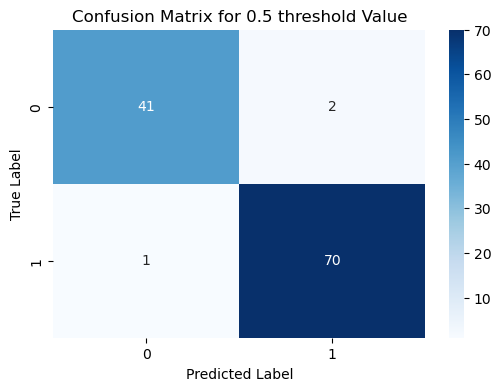

[[41  2]
 [ 1 70]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



In [25]:
# Identified confusion matrix for the default value 0.5

y_pred_test = (y_head_test >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for 0.5 threshold Value')
plt.show()

print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))



- The model’s predictions are highly successful, achieving an accuracy of 0.97. This means the model can correctly classify breast cancer patients with an accuracy rate of 98%.<br>
- First and foremost, we should emphasize the recall and precision scores to better understand how well the model generalizes. The recall score for the positive class (99%) demonstrates that the model is highly sensitive in identifying patients with cancer, successfully detecting almost all true cases.
- Precision is also emphasized in order to better understand and evaluate the predicted model. The precision score tells us that, of the patients the model predicted as having cancer, 97% actually had cancer, and only 3% were not real patients.

In [26]:
# I set the threshold value to 0.4.
# In cancer detection tasks, it is safer to use a lower threshold to reduce false negatives,
# ensuring that fewer actual cancer cases are missed, even if this leads to more false positives.
# Note: Lowering the threshold increases the model’s sensitivity (recall), 
# which is especially important in cancer detection to minimize the number of missed positive cases.
y_head_class = [1 if prob >= 0.4 else 0 for prob in y_head_test]

In [27]:
len(y_head_class)

114

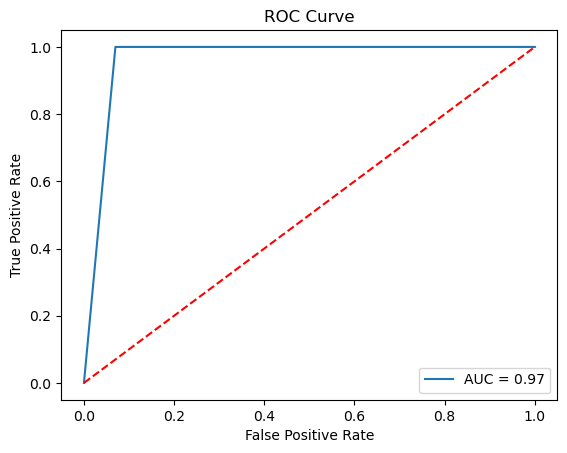

In [28]:
# Checking the ROC Curve again after the threshold update to 0.4 value
fpr, tpr, thresholds = roc_curve(y_test, y_head_class)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

**The ROC Curve after setting the threshold to 0.4** shows that the model works very well. The blue line is almost at the top, which means the model can find most cancer patients correctly. The AUC value is 0.97. This shows that the model is very good at separating cancer and non-cancer patients. In other words, the model can correctly identify 97% of the real cancer patients.

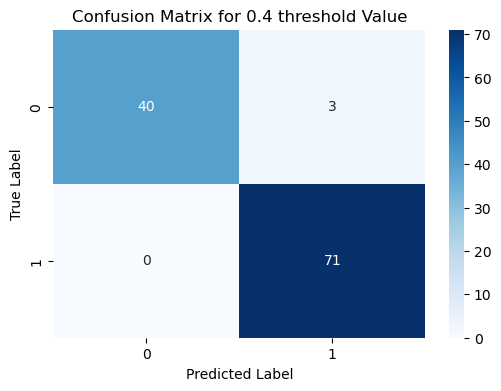

[[40  3]
 [ 0 71]]
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        43
           1       0.96      1.00      0.98        71

    accuracy                           0.97       114
   macro avg       0.98      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



In [29]:


# Identified confusion matrix
cm = confusion_matrix(y_test, y_head_class)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for 0.4 threshold Value')
plt.show()

print(confusion_matrix(y_test, y_head_class))
print(classification_report(y_test, y_head_class))



- The accuracy of the model is 0.97. This result means the model performs well, but accuracy by itself does not show the full picture. For a better evaluation, it is important to check both the recall and precision scores as well.<br>
When the recall is checked, we see a score of 100%. This shows that the model did not miss any cancer patients; it correctly found all of them.
- On the other hand, when we check the precision score, it is 96%. This means that 96% of the patients the model predicted as having cancer actually have cancer. In other words, only 4% of the predicted cancer patients were not real cancer patients (false positives).<br>
- Additionally, if the dataset is not balanced or the classes are not well separated, it is important to check the F1 score. The F1 score helps us understand the balance between precision and recall.

#### **Sklearn Model Results:**

In [30]:
from sklearn import linear_model
l_model = linear_model
log_reg = linear_model.LogisticRegression(random_state = 42,max_iter= 200)

In [31]:
log_reg.fit(x_train_scaled, y_train)

LogisticRegression(max_iter=200, random_state=42)

In [32]:
y_pred_ = log_reg.predict(x_test_scaled)

In [33]:
y_probs = log_reg.predict_proba(x_test_scaled)[:, 1]  # Pozitif sınıfın olasılıkları


In [34]:
threshold = 0.4
y_pred_custom = (y_probs > threshold).astype(int)

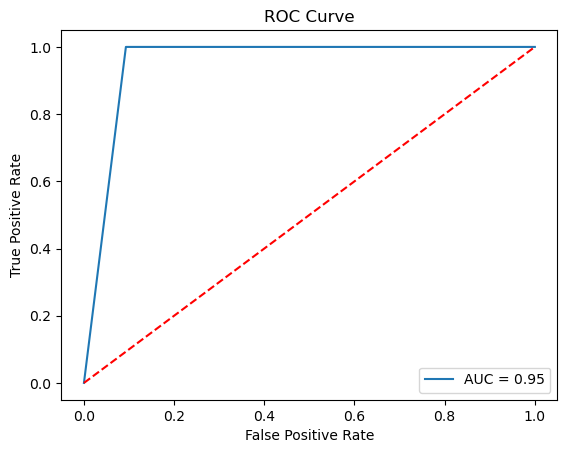

In [35]:
# Step 16 Evaluation of the Sklearn Logistic Regression Model :

fpr, tpr, thresholds = roc_curve(y_test, y_pred_custom)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


**The ROC Curve of the Sklearn Logistic Regression** shows that the model works very well. The blue line is almost at the top, which means the model can find most cancer patients correctly. The AUC value is 0.95. This shows that the model is very good at separating cancer and non-cancer patients. In other words, the model can correctly identify 95% of the real cancer patients. 

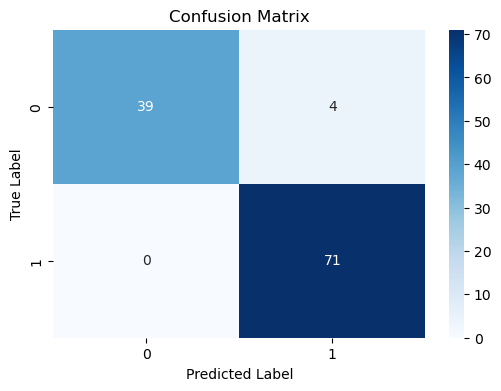

Accuracy: 0.9649122807017544
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        43
           1       0.95      1.00      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



In [36]:


cm = confusion_matrix(y_test, y_pred_custom)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred_custom))
print(classification_report(y_test, y_pred_custom))



- The accuracy of the model is 0.96. This result means the model performs well Let's also check both the recall and precision scores as well.<br>
- When the recall is checked, we see a score of 100%. This shows that the model did not miss any cancer patients; it correctly found all of them.<br>
- On the other hand, when we check the precision score, it is 95%. This means that 95% of the patients the model predicted as having cancer actually have cancer. In other words, only 5% of the predicted cancer patients were not real cancer patients (false positives).

| Model                    | **Accuracy** | **Recall (Sensitivity)** | **Precision** | **F1 Score** | **AUC**  |
|--------------------------|----------|---------------------|-----------|----------|------|
| **Manual Perceptron**        | 0.97     | 1.00                | 0.96      | 0.98     | 0.97 |
| **Sklearn Logistic Reg.**    | 0.96     | 1.00                | 0.95      | 0.97     | 0.95 |


**As a result:**
We see that both the manual perceptron model and the sklearn logistic regression model give very similar results. Their recall scores are the same, and there is only about a 1% difference in accuracy, precision, F1, and AUC scores.<br>
This shows that if we use a simple perceptron (a basic deep learning technique), we can achieve almost the same performance as with instant library models. This also demonstrates how powerful deep learning methods can be, even with a very simple architecture.<br>
In summary, both models successfully predict cancer cases with high accuracy and sensitivity. 

In [37]:
# Step 17 Additonal Step: 

# If you would like to download your project's conda environment you can use the code below.
# If your work area is jupyter or Colab you should use "!" sign to access the command prompt,
# otherwise "!" sign is not required.
# code sample:
# !conda env export > environmentbreastCancer.yaml